# WGWNet - Workload Generator to Wireless Networks

## Create the syntatic traces

In [4]:
#Importando bibliotecas

import pandas as pd
import numpy as np
import scipy
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import statsmodels as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
# Desligando avisos
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score

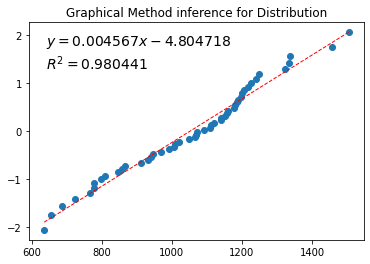

In [17]:
x = [636,656,686,725,766,778,778,798,809,847,859,867,913,932,940,947,969,991,1005,1009,1020,1050,1066,1070,1071,1093,1110,1113,1121,1140,1140,1152,1158,1160,1177,1181,1186,1189,1197,1201,1205,1218,1225,1241,1248,1324,1335,1336,1456,1504]

y = [-2.061916499,-1.75986103,-1.564726471,-1.415702095,-1.292805228,-1.186831432,-1.09273583,-1.007435602,-0.9288994917,-0.8557124298,-0.7868450986,-0.7215222836,-0.6591430373,-0.5992298686,-0.5413950857,-0.4853177307,-0.4307272994,-0.3773919437,-0.3251097111,-0.2737018893,-0.2230078307,-0.1728808327,-0.1231847715,-0.07379127386,-0.02457726109,0.02457726109,0.07379127386,0.1231847715,0.1728808327,0.2230078307,0.2737018893,0.3251097111,0.3773919437,0.4307272994,0.4853177307,0.5413950857,0.5992298686,0.6591430373,0.7215222836,0.7868450986,0.8557124298,0.9288994917,1.007435602,1.09273583,1.186831432,1.292805228,1.415702095,1.564726471,1.75986103,2.061916499]

if len(x) > len(y):
    x = x[0:len(y)]
if len(x) < len(y):
    y = y[0:len(x)]

# print("X size: ", len(x))
# print("Y size: ", len(y))

# i = 0
# for i in range(len(y)):
#     y[i] = y[i]/np.mean(y)
# i = 0
# for i in range(len(x)):
#     x[i] = x[i]/np.mean(x)
        

# print("X: ", x)
# print("Y: ", y)
plt.plot(x,y,"o")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.6f}x{z[1]:+0.6f}$\n$R^2 = {r2_score(y,y_hat):0.6f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
    fontsize=14, verticalalignment='top')
plt.title('Graphical Method inference for Distribution')
plt.show() 

In [5]:
import numpy as np
import scipy.stats as stats

mu = 0.3
sigma = 5

num_tests = 1000
num_rejects = 0
alpha = 0.05
for i in range(num_tests):
    data = np.random.normal(mu, sigma, 10000)
    # normed_data = (data - mu) / sigma    # this is okay
    # 4915/100000 = 0.05 rejects at rejection level 0.05 (as expected)
    normed_data = (data - data.mean()) / data.std()    # this is NOT okay
    # 20/100000 = 0.00 rejects at rejection level 0.05 (not expected)
    D, pval = stats.kstest(normed_data, 'norm')
    if pval < alpha:
        num_rejects += 1
ratio = float(num_rejects) / num_tests
print('{}/{} = {:.2f} rejects at rejection level {}'.format(
    num_rejects, num_tests, ratio, alpha))     

0/1000 = 0.00 rejects at rejection level 0.05


In [84]:
y = [176.000000,176.000000,66.000000,136.000000,136.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,108.000000,136.000000,456.000000,408.000000,176.000000,42.000000,42.000000,176.000000,66.000000,97.000000,247.000000,176.000000,176.000000,66.000000,247.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,448.000000,468.000000,176.000000,42.000000,42.000000,176.000000,66.000000,136.000000,456.000000,408.000000,442.000000,66.000000,738.000000,66.000000,1454.000000,66.000000,2842.000000,78.000000,896.000000,78.000000,300.000000,66.000000,160.000000,66.000000,90.000000,1469.000000,78.000000,130.000000,1392.000000,99.000000,66.000000,84.000000,1392.000000,1392.000000,1392.000000,84.000000,1392.000000,75.000000,1392.000000,1109.000000,1392.000000,551.000000,77.000000,74.000000,79.000000,275.000000,79.000000,67.000000,523.000000,79.000000,176.000000,176.000000,66.000000,42.000000,42.000000,66.000000,66.000000,176.000000,176.000000,66.000000,214.000000,554.000000,214.000000,554.000000,66.000000,66.000000,66.000000,66.000000,214.000000,554.000000,214.000000,554.000000,176.000000,176.000000,66.000000,75.000000,67.000000,176.000000,176.000000,66.000000,70.000000,136.000000,456.000000,408.000000,176.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,42.000000,42.000000,176.000000,66.000000,176.000000,176.000000,66.000000,247.000000,100.000000,161.000000,100.000000,161.000000,247.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,42.000000,42.000000,176.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,108.000000,147.000000,117.000000,42.000000,42.000000,66.000000,176.000000,66.000000,66.000000,66.000000,176.000000,176.000000,66.000000,66.000000,66.000000,66.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,448.000000,468.000000,176.000000,176.000000,66.000000,176.000000,42.000000,42.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,176.000000,176.000000,66.000000,247.000000,247.000000,176.000000,176.000000,66.000000,42.000000,42.000000,97.000000,90.000000,66.000000,104.000000,66.000000,185.000000,205.000000,90.000000,185.000000,205.000000,176.000000,176.000000,66.000000,185.000000,205.000000,448.000000,468.000000,448.000000,468.000000,66.000000,66.000000,448.000000,468.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,66.000000,66.000000,448.000000,468.000000,66.000000,66.000000,176.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,448.000000,468.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,176.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,448.000000,468.000000,324.000000,590.000000,100.000000,132.000000,74.000000,86.000000,102.000000,1392.000000,1392.000000,144.000000,84.000000,1392.000000,67.000000,75.000000,736.000000,1392.000000,1271.000000,74.000000,75.000000,92.000000,75.000000,75.000000,86.000000,102.000000,1392.000000,473.000000,84.000000,1392.000000,1392.000000,1392.000000,473.000000,86.000000,1392.000000,69.000000,75.000000,476.000000,69.000000,75.000000,220.000000,74.000000,67.000000,74.000000,66.000000,153.000000,405.000000,91.000000,363.000000,90.000000,87.000000,75.000000,106.000000,1392.000000,1392.000000,1383.000000,67.000000,66.000000,84.000000,214.000000,66.000000,66.000000,66.000000,1392.000000,75.000000,67.000000,66.000000,1024.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1057.000000,1392.000000,1392.000000,956.000000,1392.000000,1392.000000,75.000000,75.000000,75.000000,75.000000,75.000000,75.000000,1392.000000,1090.000000,75.000000,1392.000000,1392.000000,75.000000,958.000000,1392.000000,1392.000000,77.000000,77.000000,75.000000,1392.000000,1392.000000,75.000000,1392.000000,1392.000000,77.000000,1392.000000,1392.000000,77.000000,79.000000,1392.000000,1392.000000,79.000000,79.000000,1392.000000,1392.000000,1392.000000,79.000000,94.000000,81.000000,1392.000000,1392.000000,1392.000000,81.000000,81.000000,98.000000,1392.000000,1392.000000,81.000000,1392.000000,1392.000000,81.000000,1392.000000,1392.000000,83.000000,81.000000,1392.000000,1392.000000,83.000000,81.000000,1392.000000,1392.000000,1392.000000,1392.000000,81.000000,83.000000,81.000000,855.000000,83.000000,75.000000,214.000000,554.000000,176.000000,176.000000,66.000000,88.000000,104.000000,1392.000000,365.000000,84.000000,1392.000000,1392.000000,1392.000000,365.000000,1392.000000,1392.000000,1392.000000,86.000000,1392.000000,69.000000,75.000000,409.000000,69.000000,75.000000,768.000000,409.000000,75.000000,67.000000,816.000000,91.000000,69.000000,75.000000,67.000000,214.000000,554.000000,214.000000,554.000000,214.000000,554.000000,42.000000,42.000000,92.000000,66.000000,92.000000,66.000000,176.000000,176.000000,66.000000,247.000000,247.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,66.000000,66.000000,97.000000,66.000000,104.000000,66.000000,75.000000,67.000000,176.000000,176.000000,66.000000,66.000000,66.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,448.000000,468.000000,108.000000,108.000000,108.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,42.000000,42.000000,109.000000,109.000000,194.000000,157.000000,74.000000,74.000000,74.000000,66.000000,583.000000,74.000000,54.000000,66.000000,2642.000000,66.000000,882.000000,66.000000,141.000000,117.000000,66.000000,117.000000,66.000000,283.000000,173.000000,66.000000,646.000000,66.000000,176.000000,180.000000,66.000000,176.000000,176.000000,66.000000,66.000000,176.000000,66.000000,176.000000,66.000000,108.000000,109.000000,194.000000,74.000000,97.000000,66.000000,74.000000,66.000000,583.000000,104.000000,66.000000,66.000000,882.000000,78.000000,1354.000000,78.000000,1354.000000,66.000000,141.000000,117.000000,66.000000,176.000000,176.000000,66.000000,117.000000,66.000000,284.000000,285.000000,66.000000,665.000000,66.000000,42.000000,42.000000,66.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,176.000000,176.000000,66.000000,247.000000,247.000000,66.000000,66.000000,88.000000,104.000000,1392.000000,364.000000,176.000000,1392.000000,1392.000000,83.000000,1392.000000,364.000000,176.000000,66.000000,1392.000000,1392.000000,86.000000,1392.000000,69.000000,85.000000,389.000000,83.000000,69.000000,75.000000,75.000000,556.000000,90.000000,69.000000,77.000000,556.000000,106.000000,1392.000000,816.000000,77.000000,84.000000,1392.000000,75.000000,834.000000,67.000000,1054.000000,69.000000,75.000000,556.000000,67.000000,66.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,176.000000,176.000000,66.000000,75.000000,67.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,111.000000,136.000000,456.000000,408.000000,97.000000,66.000000,104.000000,66.000000,448.000000,468.000000,66.000000,66.000000,97.000000,66.000000,176.000000,176.000000,66.000000,66.000000,97.000000,97.000000,176.000000,176.000000,66.000000,97.000000,66.000000,66.000000,247.000000,97.000000,66.000000,108.000000,104.000000,66.000000,176.000000,176.000000,66.000000,247.000000,97.000000,66.000000,97.000000,66.000000,78.000000,66.000000,54.000000,66.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,42.000000,42.000000,176.000000,176.000000,66.000000,97.000000,214.000000,554.000000,176.000000,176.000000,66.000000,214.000000,554.000000,214.000000,554.000000,90.000000,214.000000,554.000000,185.000000,205.000000,185.000000,205.000000,90.000000,185.000000,205.000000,448.000000,468.000000,448.000000,468.000000,176.000000,176.000000,66.000000,448.000000,468.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,448.000000,468.000000,136.000000,456.000000,408.000000,42.000000,42.000000,176.000000,176.000000,66.000000,448.000000,468.000000,97.000000,66.000000,66.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,66.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,66.000000,66.000000,247.000000,448.000000,468.000000,247.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,90.000000,130.000000,1392.000000,84.000000,1392.000000,75.000000,1048.000000,1392.000000,921.000000,75.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,42.000000,42.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,87.000000,140.000000,74.000000,74.000000,176.000000,176.000000,66.000000,74.000000,66.000000,583.000000,74.000000,66.000000,583.000000,66.000000,278.000000,66.000000,130.000000,158.000000,420.000000,928.000000,66.000000,278.000000,66.000000,130.000000,223.000000,66.000000,140.000000,66.000000,97.000000,66.000000,101.000000,66.000000,97.000000,223.000000,66.000000,140.000000,66.000000,66.000000,66.000000,268.000000,66.000000,75.000000,67.000000,176.000000,176.000000,66.000000,97.000000,176.000000,176.000000,66.000000,448.000000,468.000000,66.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,66.000000,66.000000,176.000000,176.000000,66.000000,66.000000,66.000000,176.000000,176.000000,66.000000,247.000000,97.000000,66.000000,104.000000,66.000000,247.000000,108.000000,176.000000,176.000000,66.000000,100.000000,161.000000,100.000000,161.000000,42.000000,42.000000,176.000000,176.000000,66.000000,136.000000,456.000000,408.000000,176.000000,176.000000,176.000000,66.000000,78.000000,176.000000,66.000000,176.000000,66.000000,176.000000,78.000000,66.000000,66.000000,66.000000,66.000000,176.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,136.000000,456.000000,456.000000,408.000000,176.000000,66.000000,66.000000,66.000000,176.000000,176.000000,66.000000,66.000000,66.000000,214.000000,554.000000,105.000000,66.000000,66.000000,105.000000,66.000000,66.000000,66.000000,66.000000,66.000000,214.000000,554.000000,176.000000,176.000000,66.000000,214.000000,554.000000,66.000000,66.000000,214.000000,554.000000,42.000000,42.000000,176.000000,176.000000,66.000000,448.000000,468.000000,136.000000,456.000000,408.000000,176.000000,176.000000,66.000000,247.000000,247.000000,176.000000,176.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,42.000000,42.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000,66.000000,66.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,176.000000,66.000000,90.000000,185.000000,205.000000,66.000000,66.000000,185.000000,205.000000,90.000000,205.000000,185.000000,448.000000,468.000000,468.000000,448.000000,176.000000,180.000000,66.000000,176.000000,66.000000,176.000000,66.000000,448.000000,468.000000,66.000000,66.000000,66.000000,54.000000,448.000000,468.000000,176.000000,176.000000,66.000000,42.000000,42.000000,97.000000,66.000000,104.000000,66.000000,176.000000,176.000000,66.000000,74.000000,86.000000,102.000000,1392.000000,1392.000000,143.000000,84.000000,1392.000000,75.000000,67.000000,733.000000,1264.000000,1392.000000,74.000000,77.000000,75.000000,176.000000,75.000000,733.000000,448.000000,468.000000,75.000000,86.000000,102.000000,1392.000000,472.000000,84.000000,1392.000000,75.000000,67.000000,476.000000,69.000000,75.000000,220.000000,74.000000,67.000000,382.000000,363.000000,165.000000,75.000000,91.000000,1392.000000,1392.000000,1377.000000,67.000000,84.000000,1392.000000,67.000000,75.000000,1024.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1050.000000,1392.000000,1392.000000,1392.000000,1141.000000,1392.000000,1392.000000,904.000000,1392.000000,960.000000,1392.000000,1392.000000,75.000000,75.000000,77.000000,75.000000,75.000000,75.000000,77.000000,75.000000,1392.000000,75.000000,77.000000,77.000000,77.000000,77.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,1392.000000,77.000000,79.000000,77.000000,77.000000,79.000000,90.000000,77.000000,79.000000,79.000000,77.000000,79.000000,1392.000000,77.000000,1392.000000,94.000000,1392.000000,1392.000000,77.000000,1392.000000,1392.000000,1392.000000,79.000000,75.000000,1392.000000,1392.000000,1392.000000,77.000000,77.000000,84.000000,77.000000,88.000000,104.000000,1392.000000,365.000000,1392.000000,84.000000,1392.000000,75.000000,67.000000,1392.000000,75.000000,409.000000,91.000000,769.000000,69.000000,75.000000,67.000000,816.000000,69.000000,75.000000,74.000000,176.000000,176.000000,66.000000,247.000000,247.000000,74.000000,176.000000,176.000000,66.000000,176.000000,176.000000,66.000000]

MAX(Y):  2842.0
MAX(Random):  3808.1268126230043
PARAM:  (0.29100963901922167, 1.3561153995937802, 41.99999999999999, 3776.0809529542935)
arg:  0.29100963901922167 1.3561153995937802
loc:  41.99999999999999
scale:  3776.0809529542935
Dist:  <scipy.stats._continuous_distns.beta_gen object at 0x7f1ea2df6af0>


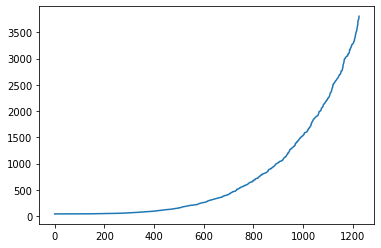

X size:  1226
Y size:  1226


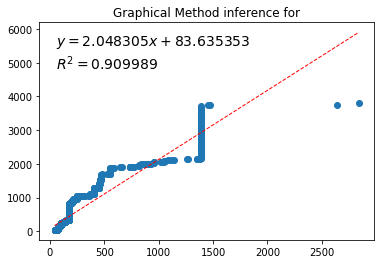

In [96]:
y = [49.9,50.7,52,50.8,49.2,49.6,50.4,51.5,52.7,44.5,54,58.6,46.1,52.2,52.1,56.1,49.8,51.5,54,58.4,53.1,47.5,51.1,47.8,46.7,48.5,49.9,46.9,51.3,37.2,47.4,39.5,45.9,45.6,53.3,54.3,53,58.2,50.5,59.6,56.8,46.7,40.4,49.7,46.7,52.9,50.2,53.5,53.5,53.5,46.1,49.2,44.7,51.2,51.3,52.1,52,50.6,51.8,45.6,47.4,45.4,45,47.9,55.3,45.1,51.8,47.9,42.4,39.7,55.7,51.7,45.8,43.8,55.9,52.6,49.1,54.3,43.3,56.9,57.3,48,48.2,43.8,43,45.7,45.5,53.5,40.6,41,43.1,49.9,52.3,54.7,48.1,40.1,52.1,48.8,50.9,44.4]
y = t_y
np.array(y)
sc=StandardScaler()
yy = y.reshape (-1,1)
sc.fit(yy)
y_std = sc.transform(yy)
y_std = y_std.flatten()
del yy
# y = y_std
parameters = []

sig = [:1500]
win = [1500:]
filtered = signal.convolve(sig, win, mode='same') / sum(win)

fig, (ax_orig, ax_win, ax_filt) = plt.subplots(3, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
fig.tight_layout()
fig.show()
dist = getattr(scipy.stats, 'beta')
param = dist.fit(y)
parameters.append(param)


arg = param[:-2]
loc = param[-2]
scale = param[-1]
r_N = dist.rvs(loc=loc, scale=scale, *arg, size=len(y))

print("MAX(Y): ", max(y))
print("MAX(Random): ", max(r_N))
print("PARAM: ", param)
print("arg: ", *param[0:-2])
print("loc: ", param[-2])
print("scale: ", param[-1])
print("Dist: ", dist)
# print("Random: ", r_N)
r_N.sort()
plt.plot(r_N)
plt.show()

x = y
y = r_N

# y = size_ns3
# x = t_size

x = np.array(x)
y = np.array(y)

x.sort()
y.sort()
if len(x) > len(y):
    x = x[0:len(y)]
if len(x) < len(y):
    y = y[0:len(x)]

print("X size: ", len(x))
print("Y size: ", len(y))

# print("X: ", x)
# print("Y: ", y)
plt.plot(x,y,"o")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.6f}x{z[1]:+0.6f}$\n$R^2 = {r2_score(y,y_hat):0.6f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
    fontsize=14, verticalalignment='top')
plt.title('Graphical Method inference for')
plt.show() 

## Workload Generator

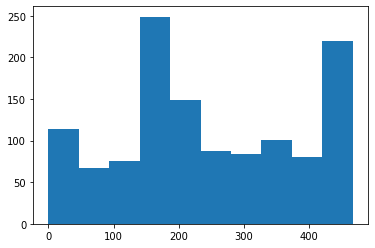

Distribution:  expon
Confidence level:  0.001
Reject of Null:  Reject the Null Hypothesis, Fails to Reject the Null Hypothesis
D observed:  0.2433528139250619
D critical:  0.05569155910281013
 
Distribution:  gamma
Confidence level:  0.001
Reject of Null:  Reject the Null Hypothesis, Fails to Reject the Null Hypothesis
D observed:  0.09808216378713353
D critical:  0.05569155910281013
 
Distribution:  lognorm
Confidence level:  0.001
Reject of Null:  Reject the Null Hypothesis, Fails to Reject the Null Hypothesis
D observed:  0.09372171573760224
D critical:  0.05569155910281013
 
Distribution:  norm
Confidence level:  0.001
Reject of Null:  Reject the Null Hypothesis, Fails to Reject the Null Hypothesis
D observed:  0.10832098763264647
D critical:  0.05569155910281013
 
Distribution:  loggamma
Confidence level:  0.001
Reject of Null:  Reject the Null Hypothesis, Fails to Reject the Null Hypothesis
D observed:  0.10697544807796378
D critical:  0.05569155910281013
 
Distribution:  triang


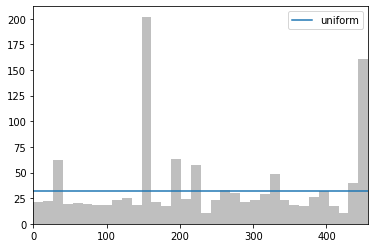


Distribution parameters:
------------------------

Distribution: uniform
Parameters: (0.0, 467.556903)
Dist:  <scipy.stats._continuous_distns.uniform_gen object at 0x7fa522867ac0>


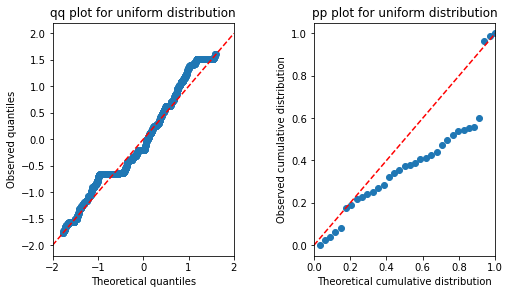

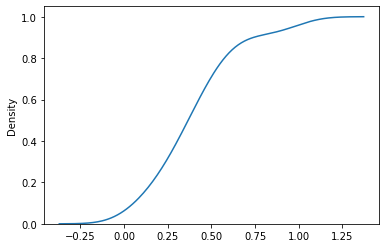

In [94]:
# Option "Trace" "PB" "SS"
WGNet_Input = "PD"
if WGNet_Input == "PD":
    data_set = np.loadtxt("parameters/Times.txt", usecols=0)


    data_set = np.array(data_set)
    y = data_set

    # Indexar o vetor criado anteriormente Create an index array (x) for data

    x = np.arange(len(y))
    size = len(x)
    nbins = int(np.sqrt(size))

    #Plot histograma:
    plt.hist(y)
    plt.show()


    #Com ajuda da lib Pandas podemos encontrar algumas estatísticas importantes.
    y_df = pd.DataFrame(y, columns=['Data'])
    y_df.describe()
    
    # Variáveis para definir o método de geração de carga de trabalho por meio de Distribuições de Probabilidade
    cdf = []
    # Variável "para teorical cumulative distributin function"
    tcdf = True
    # Variável para "empirical cumulative distributin function"
    ecdf = False
    
    if tcdf:
        #Primeiro, vamos normalizar os dados
        sc=StandardScaler()
        yy = y.reshape (-1,1)
        sc.fit(yy)
        y_std = sc.transform(yy)
        y_std = y_std.flatten()
        y_std
        del yy

        #Python pode relatar avisos enquanto executa as distribuições

        # Mais distribuições podem ser encontradas no site do Scipy
        # Veja https://docs.scipy.org/doc/scipy/reference/stats.html para mais detalhes
        dist_names = ['expon',
                      'gamma',
                      'lognorm',
                      'norm',
                      'loggamma',
                      'triang',
                      'uniform',
                      'weibull_min', 
                      'weibull_max',
                      'logistic',
                      'laplace',
                      'gamma',
                      'lognorm',
                      'loguniform']
        # Get the QQ and Chi-squared method of inference
        #Configurar listas vazias para receber os resultados
        chi_square = []
        p_values = []
        #--------------------------------------------------------#
        # Chi-square method
        
        # Configurar os 50 intervalos de classe para o teste qui-quadrado
        # Os dados observados serão distribuídos uniformemente em todos os inervalos de classes
        percentile_bins = np.linspace(0,100,nbins)
        percentile_cutoffs = np.percentile(y_std, percentile_bins)
        observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
        cum_observed_frequency = np.cumsum(observed_frequency)

        # Repetir para as distribuições candidatas
        for distribution in dist_names:
            # Configure a distribuição e obtenha parâmetros de distribuição ajustados
            dist = getattr(scipy.stats, distribution)
            param = dist.fit(y_std)

            # Obter a estatística P do teste KS, arredondar para 5 casas decimais
            #  Configurar os 50 intervalos de classe para o teste qui-quadrado
            # Os dados observados serão distribuídos uniformemente em todos os inervalos de classes
            y_sort = y.sort()
            percentile = np.linspace(0,100,len(y))
            percentile_cut = np.percentile(y_std, percentile)
            
            # Criando CDF da teórica
            Ft = dist.cdf(percentile_cut, *param[:-2], loc=param[-2], scale=param[-1])
            # Criando CDF Inversa 
            Ft_ = dist.ppf(percentile_cut, *param[:-2], loc=param[-2], scale=param[-1])
            
            Fe = []
            Fe_ = []
            # Criando ECDFs
            for i in range(len(y)):
                # ecdf i-1/n
                Fe.append((i-1)/len(y))
                # ecdf i/n
                Fe_.append(i/len(y))

            Fe = np.array(Fe)
            Fe_ = np.array(Fe_)
            Ft = np.array(Ft)
            Ft_ = np.array(Ft_)
            
            # Ft(t)-FE-(i),FE+(i)-Ft(t)
            Ft_Fe_ = np.subtract(Ft, Fe_)
            Fe_Ft = np.subtract(Fe, Ft)
            
            # Max(Ft(t)-FE-(i),FE+(i)-Ft(t))
            Dcal_max = np.maximum(Ft_Fe_, Fe_Ft)
            
            # Dcal= Max(Max (Ft(t)-FE-(i),FE+(i)-Ft(t)))
            Dcal = np.max(Dcal_max)

            # 99.95 of confidence level
            alpha = 0.001
            
            
            if size > 35:
                if alpha == 0.10:
                    D_critico = 1.22/np.sqrt(len(y))
                
                if alpha == 0.05:
                    D_critico = 1.36/np.sqrt(len(y))
                
                if alpha == 0.025:
                    D_critico = 1.48/np.sqrt(len(y))
                
                if alpha == 0.01:
                    D_critico = 1.63/np.sqrt(len(y))
                
                if alpha == 0.005:
                    D_critico = 1.73/np.sqrt(len(y))
                if alpha == 0.001:
                    D_critico = 1.95/np.sqrt(len(y))

                if Dcal > D_critico:
                    rejects = "Reject the Null Hypothesis, Fails to Reject the Null Hypothesis"

            print("Distribution: ",distribution)
            print("Confidence level: ", alpha)
            print("Reject of Null: ", rejects)
            print("D observed: ", Dcal)
            print("D critical: ", D_critico)
            print(" ")
            
            # DEFAULT
            # p = scipy.stats.kstest(y_std, distribution, args=param)[1]
            p = Dcal
            # p = np.around(p, 5)
            p_values.append(p)    

            # Obter contagens esperadas nos percentis
            # Isso se baseia em uma 'função de distribuição acumulada' (cdf)
            cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                                  scale=param[-1])
            expected_frequency = []
            for bin in range(len(percentile_bins)-1):
                expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
                expected_frequency.append(expected_cdf_area)

            # calculando o qui-quadrado
            expected_frequency = np.array(expected_frequency) * size
            cum_expected_frequency = np.cumsum(expected_frequency)
            ss = sum (((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency)
            chi_square.append(ss)

        # Agrupar os resultados e classificar por qualidade de ajuste (melhor na parte superior)

        results = pd.DataFrame()
        results['Distribution'] = dist_names
        results['chi_square'] = chi_square
        results['p_value'] = p_values
        results.sort_values(['chi_square'], inplace=True)

        # Apresentar os resultados em uma tabela

        print ('\nDistributions sorted by goodness of fit:')
        print ('----------------------------------------')
        print (results)




        # Divida os dados observados em N posições para plotagem (isso pode ser alterado)
        bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99), nbins)

        # Crie o gráfico
        h = plt.hist(y, bins = bin_cutoffs, color='0.75')

        # Receba as três principais distribuições da fase anterior
        number_distributions_to_plot = 1
        dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

        # Crie uma lista vazia para armazenar parâmetros de distribuição ajustada
        parameters = []

        columns = ["length", "time"]
        df = pd.DataFrame(columns = columns)

        length = []
        time = []

        # Faça um loop pelas distribuições para obter o ajuste e os parâmetros da linha
        for dist_name in dist_names:
            # Set up distribution and store distribution paraemters
            dist = getattr(scipy.stats, dist_name)
            param = dist.fit(y)
            parameters.append(param)

            

            # Obter linha para cada distribuição (e dimensionar para corresponder aos dados observados)
            pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
            scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
            pdf_fitted *= scale_pdf

            # Adicione a linha ao gráfico
            plt.plot(pdf_fitted, label=dist_name)

            # Defina o eixo gráfico x para conter 99% dos dados
            # Isso pode ser removido, mas, às vezes, dados fora de padrão tornam o gráfico menos claro
            plt.xlim(0,np.percentile(y,99))
          

            ############ RANDOM GENERATE #############
            arg = param[:-2]
            loc = param[-2]
            scale = param[-1]
            
            time = dist.rvs(loc=loc, scale=scale, *arg, size=10)

            print("TIME: ", time)
            print("DIST: ", dist)
            print("ARG: ", arg)
            print("LOC: ", loc)
            print("SCALE: ", scale)

        # Adicionar legenda
        plt.legend()
        plt.show()

        # Armazenar parâmetros de distribuição em um quadro de dados (isso também pode ser salvo)
        dist_parameters = pd.DataFrame()
        dist_parameters['Distribution'] = (
                results['Distribution'].iloc[0:number_distributions_to_plot])
        dist_parameters['Distribution parameters'] = parameters

        # Printar os parâmetros
        print ('\nDistribution parameters:')
        print ('------------------------')
        
        
        for index, row in dist_parameters.iterrows():
            print ('\nDistribution:', row[0])
            print ('Parameters:', row[1])

       
        # Save parameters in DataFrames and Export to .txt
        df = pd.DataFrame(list(zip(time)), columns=['time'])

        

        np.savetxt(r'time.txt', df['time'], fmt='%f')



        #--------------------------------------------------------#
        ## qq and pp plots

        data = y_std.copy()
        data.sort()

        # Loop through selected distributions (as previously selected)

        for distribution in dist_names:
            # Set up distribution
            dist = getattr(scipy.stats, distribution)
            print("Dist: ",dist)
            param = dist.fit(y_std)

            # Get random numbers from distribution
            norm = dist.rvs(*param[0:-2],loc=param[-2], scale=param[-1],size = size)
            norm.sort()
            #print("Norm: ",norm)
            # Create figure
            fig = plt.figure(figsize=(8,5)) 

            # qq plot
            ax1 = fig.add_subplot(121) # Grid of 2x2, this is suplot 1
            ax1.plot(norm,data,"o")
            min_value = np.floor(min(min(norm),min(data)))
            max_value = np.ceil(max(max(norm),max(data)))
            ax1.plot([min_value,max_value],[min_value,max_value],'r--')
            ax1.set_xlim(min_value,max_value)
            ax1.set_xlabel('Theoretical quantiles')
            ax1.set_ylabel('Observed quantiles')
            title = 'qq plot for ' + distribution +' distribution'
            ax1.set_title(title)

            # pp plot
            ax2 = fig.add_subplot(122)
            #print("Norm: ",norm)
            # Calculate cumulative distributions
            bins = np.percentile(norm,range(0,nbins))
            #print("Bins: ", bins)
            data_counts, bins = np.histogram(data,bins)
            norm_counts, bins = np.histogram(norm,bins)
            #print("Norm_Counts: ",norm_counts)
            #print("Data_Counts: ",data_counts)
            cum_data = np.cumsum(data_counts)
            cum_norm = np.cumsum(norm_counts)

            cum_data = cum_data / max(cum_data)
            cum_norm = cum_norm / max(cum_norm)
            #print("Cum_data: ",cum_data)
            #print("Cum_norm: ",cum_norm)
            # plot
            ax2.plot(cum_norm,cum_data,"o")
            min_value = np.floor(min(min(cum_norm),min(cum_data)))
            max_value = np.ceil(max(max(cum_norm),max(cum_data)))
            ax2.plot([min_value,max_value],[min_value,max_value],'r--')
            ax2.set_xlim(min_value,max_value)
            ax2.set_xlabel('Theoretical cumulative distribution')
            ax2.set_ylabel('Observed cumulative distribution')
            title = 'pp plot for ' + distribution +' distribution'
            ax2.set_title(title)
            
            # Display plot    
            plt.tight_layout(pad=4)
            plt.show()
            cdf = cum_data


    if ecdf:
#         y_df = np.cumsum(y_df)
        for i in range(len(y)):
            cdf.append(i/len(y))
        cdf = y
        

# if WGNet_Input == "SS":
    
if WGNet_Input == "Trace":

#     See all continuous distributions available in scipy.stats
#     continuous_dist = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)]
#     print(continuous_dist)

#     Precisa encontrar o código para detalhar as distribuições


#     Number of samples
    n = np.linspace(0,1,1000)
#     Parameter 1
    p1 = 0
#     Parameter 2
    p2 = 1
#     Parameter n
#     pn = 0

#     Vector cdf to storage random numbers = DISTRIBUIÇÃO.rvs(n, p1, p2, pn)
    
   
    cdf = np.array(stats.norm.cdf(n,p1,p2))
 

ax = sns.distplot(cdf, hist=False, kde_kws=dict(cumulative=True))


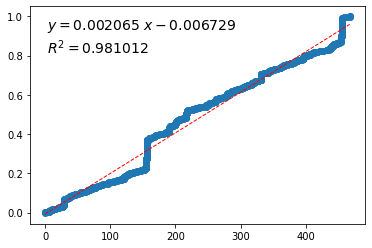

In [95]:
b = np.linspace(0,1,len(y))
a = y
# plt.suptitle('Scatter plot')
# plt.xlabel('a')
# plt.ylabel('b')
# plt.scatter(a, b)

# z = np.polyfit(a.flatten(), b.flatten(), 1)
# p = np.poly1d(z)
# plt.plot(a,p(a),"r--")
# plt.title("y=%.6fx+%.6f"%(z[0],z[1])) 

# plt.show()

from sklearn.metrics import r2_score
x = a
y = b
plt.plot(x,y,"o")
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)
text = f"$y={z[0]:0.6f}\;x{z[1]:+0.6f}$\n$R^2 = {sk.r2_score(y,y_hat):0.6f}$"
plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')
plt.show()

In [70]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
# contingency table
# table = [	[10, 20, 30],
# 			[6,  9,  17]]
table = y
table[0] = 0.000000000000000000001
print(table)
stat, p, dof, expected = chi2_contingency(table)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[1.00000000e-21 4.83400000e-03 4.86200000e-03 ... 4.67491193e+02
 4.67556876e+02 4.67556903e+02]
dof=0
[1.00000000e-21 4.83400000e-03 4.86200000e-03 ... 4.67491193e+02
 4.67556876e+02 4.67556903e+02]
probability=0.950, critical=nan, stat=0.000
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)


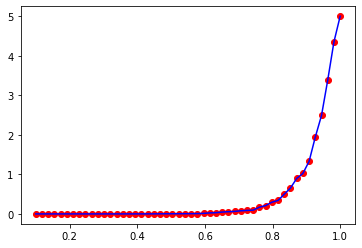

97.5 percentile: 4.0975749999999875
0.0010144999999823772


TypeError: object of type 'numpy.float64' has no len()

In [46]:
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import random

data_set = np.loadtxt("parameters/Times.txt", usecols=0)


data_set = np.array(data_set)
y = data_set
# obtendo os tempos entre pacotes do trace
sub = []
i=0
for i in range(len(y)-1):
    sub.append(y[i+1] - y[i])
# print (sub)

# Criando ECDF inversa para gerar os números aleatórios dos dados empíricos
sample = sub

sample_edf = edf.ECDF(sample)

slope_changes = sorted(set(sample))

sample_edf_values_at_slope_changes = [ sample_edf(item) for item in slope_changes]
inverted_edf = interp1d(sample_edf_values_at_slope_changes, slope_changes)

x = np.linspace(0.1, 1)
y = inverted_edf(x)
plt.plot(x, y, 'ro', x, y, 'b-')
plt.show()

print ('97.5 percentile:', inverted_edf(0.975))
print (random.choice(y))


In [37]:
## Create a random variate generation:

In [118]:
### INVERSE TRANSFORM METHOD (Continuos)###

def expon_inv(u):
    a = 1
    return -a*np.log(1-u)

def burr_inv(u):
    k = 1
    c = 2
    return np.power(((np.power(1-u,-1/k))-1),1/c)

def laplace_inv(u):
    if (u.all() <= 0.5):
        return np.log(2*u)
    else:
        return -np.log(2*(1-u))
def logistic_inv(u):
    return np.log((1-u))/u

def pareto_inv(u):
    c = 1
    return np.power((1-u),-1/c)



def inv_distribution(argument, u):
    switcher = {
        1: expon_inv,
        2: burr_inv,
        3: laplace_inv,
        4: logistic_inv,
        5: pareto_inv,
    }
    # Get the function from switcher dictionary
    func = switcher.get(argument, lambda: "Invalid distribution")
    # Execute the function
    return func(u)

def inverse():
    dist = 5
    u = np.random.uniform(0,1,1000)
    # u = 0.2

    cdf_inv = inv_distribution(dist, u)
    # expinv = expon_icdf(u)
    nbins = int(np.sqrt(len(cdf_inv)))

    plt.hist(cdf_inv, bins=nbins, normed=True, histtype="step")
#     plt.plot(cdf_inv, "--") # Random varietes generated
#     plt.plot(u, "-") # Originals random numbers
    plt.show()
inverse()

# Criar os valores aleatório com distribuições independente das técnicas utilizadas;
# Se a distribuição a composição (soma de pdf, pode ser de duas distribuições, possui peso);
# Convolução (Soma de variáveis aleatórias de uma mesma distribuição);
# Pesquisar módulo para criar pacotes de acordo com os valores gerados pelo WGWNet;
# Teste bed mandar e-mail para verificar qual computador pode ser utilizado.
 

AttributeError: 'Polygon' object has no property 'normed'

In [32]:
### COMPOSITION METHOD (Continuos)###
def composition():

    return 

U1 = np.array(np.random.uniform(0,1,1000))
U2 = np.array(np.random.uniform(0,1,1000))

nbins = int(np.sqrt(len(U1)))

X = []
X1 = []
X2 = []
i = 0
j = 0
# for i in range(len(U1)):
# while True:
for i in range(len(U1)):
    if U1[i]<0.5:
        X1 = (np.sqrt(U2))-1
    else:
        X2 = 1-np.sqrt(1-U2)

X = np.concatenate((X1,X2))

# plt.hist(X1, bins=nbins, normed=True, histtype="step")
# plt.hist(X2, bins=nbins, normed=True, histtype="step")
plt.hist(X, bins=nbins, normed=True, histtype="step")
# plt.plot(data_sorteda, pa)
# plt.plot(data_sortedb, pb)
# plt.plot(CDF, pcdf)
plt.show()

AttributeError: 'Polygon' object has no property 'normed'

In [119]:
### CONVOLUTION METHOD (Continuos)###

def convolution(cdf):
    return 

U1 = (np.array(np.random.uniform(0,1,1000)))-0.5
U2 = (np.array(np.random.uniform(0,1,1000)))-0.5

X = U1 + U2

plt.hist(X, bins=nbins, normed=True, histtype="step")
plt.show()

AttributeError: 'Polygon' object has no property 'normed'

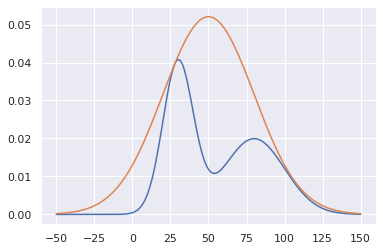

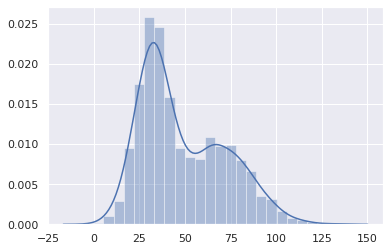

In [120]:
### ACCEPTABLE-REJECTION METHOD (Continuos)###

import numpy as np
import scipy.stats as st
import seaborn as sns
import matplotlib.pyplot as plt


sns.set()


def p(x):
    return st.norm.pdf(x, loc=30, scale=10) + st.norm.pdf(x, loc=80, scale=20)

def q(x):
    return st.norm.pdf(x, loc=50, scale=30)

x = np.arange(-50, 151)
k = max(p(x) / q(x))

def rejection_sampling(iter):
    samples = []

    for i in range(iter):
        z = np.random.normal(50, 30)
        u = np.random.uniform(0, 1)
#         print(i)
        if u <= p(z):
            samples.append(z)
    return np.array(samples)


if __name__ == '__main__':
    plt.plot(x, p(x))
    plt.plot(x, k*q(x))
    plt.show()


    s = rejection_sampling(iter=100000)
    sns.distplot(s)

In [28]:
def caracterization(cdf):
    return


In [123]:
# Main function select the method to generate random variates

method = "rejection_sampling"
if method == "inverse":
    inverse()
if method == "composition":
    composition()
if method == "convolution":
    convolution()
if method == "caracterization":
    caracterization()
if method == "accept_reject":
    accept_reject()

def distribution(argument, u):
    switcher = {
        1: inverse,
        2: composition,
        3: convolution,
        4: caracterization,
        5: accept_reject,
    }
    # Get the function from switcher dictionary
    func = switcher.get(argument, lambda: "Invalid distribution")
    # Execute the function
    return func(u)

In [124]:
def translation(cdf):
    return 
# Random Variate X:
X = np.random.exponential(1)
#scale
a = 1
#location
b = 0.1

Y = (a*X) + b
# or
g(x)= (np.power(a,-1))*f((y-b)/a)

Y = pdf(g(x))

SyntaxError: cannot assign to function call (<ipython-input-124-152128fd539e>, line 12)

## Using terminal to convert .pcap file to .xml | .pdml | .psml

In [4]:
# tshark [ -i <capture interface>|- ] [ -f <capture filter> ] [ -2 ] [ -r <infile> ] [ -w <outfile>|- ] [ options ] [ <filter> ]
# -T pdml|psml|ps|text|fields

# Need more filters for specify applications
# os.system("tshark -r trace-files/trace1.pcap -T pdml > trace-files/test_trace.pdml")
os.system("sudo chmod 777 fifth.pcap")
os.system("termshark -r fifth.pcap -T fields -E separator=/t  -e ip.len > scratch/size.txt")
os.system("termshark -r fifth.pcap -T fields -E separator=/t -e frame.time_delta_displayed > scratch/time.txt")
os.system("chmod 777 scratch/size.txt")
os.system("chmod 777 scratch/time.txt")




0

## Read and Filter .pdml file convert for T-Shark

In [105]:

import xml.etree.ElementTree as etree
import pandas as pd
import numpy as np

ifile = open('trace-files/test_trace.pdml','r')

columns = ["length", "time"]
df = pd.DataFrame(columns = columns)

length = []
time = []
for line in ifile.readlines(): 
    if ("frame.len" in line):
        length.append(line)
    
    if ("frame.time_relative" in line):
        time.append(line)

ifile.close()
# Save parameters in DataFrames and Export to .txt
df = pd.DataFrame(list(zip(length, time)), columns=['length', 'time'])


df['length'] = df['length'].str.split('show="').str[-1]
df['time'] = df['time'].str.split('show="').str[-1]

df['length'] = df['length'].str.split('"').str[0]
df['time'] = df['time'].str.split('"').str[0]
df
# df["length"] = pd.to_numeric(df["length"],errors='coerce')
# df["time"] = pd.to_numeric(df["time"],errors='coerce')
# df.dropna(subset = ["length","time"], inplace=True)

np.savetxt(r'parameters/Times.txt', df['Time'], fmt='%f')

np.savetxt(r'parameters/SizePackets.txt', df['Length'], fmt='%f')

,length,time
0,176,0.000000000
1,176,0.004834000
2,66,0.004862000
3,136,4.702668000
4,136,4.702703000
...,...,...
1221,176,462.489930000
1222,66,462.489952000
1223,176,467.491193000
1224,176,467.556876000


## Execute NS3 Files

In [13]:
import os

os.system("./run.sh")

256

## Create DataFrames of file .xml get of NS3 Animator

### Dataframe of .xml TCP

In [109]:
import pandas as pd 
import xml.etree.ElementTree as etree

tree = etree.parse("lab2 files/test_lab2_animation.xml")
# tree = etree.parse("lab2 files/test_output_TCP.xml")

root = tree.getroot()
columns = ["length", "time"]

df_TCP = pd.DataFrame(columns = columns)

for node in root: 
    length = node.attrib.get("meta-info")
    time = node.attrib.get("fbTx")
    # time = node.find("time").text if node is not None else None
    df_TCP = df_TCP.append(pd.Series([length, time], index = columns), ignore_index = True)

df_TCP['length'] = df_TCP['length'].str.split('length: ').str[-1]
df_TCP['length'] = df_TCP['length'].str.split(' ').str[0]


df_TCP["length"] = pd.to_numeric(df_TCP["length"],errors='coerce')
df_TCP.dropna(subset = ["length"], inplace=True)

df_TCP[:100]

,length,time
64,56.0,1
65,56.0,1.002928
66,56.0,1.005856
67,56.0,1.008784
68,56.0,1.011712
...,...,...
159,52.0,1.305743984
160,182.0,1.307808001
161,588.0,1.309808001
162,182.0,1.310399986


### Dataframe of .xml UDP

In [110]:
import xml.etree.ElementTree as etree_UDP
tree_UDP = etree_UDP.parse("lab2 files/test_lab2_animation.xml")
root_UDP = tree_UDP.getroot()
columns = ["length", "time"]

df_UDP = pd.DataFrame(columns = columns)

for node in root_UDP: 
    length = node.attrib.get("meta-info")
    time = node.attrib.get("fbTx")
    # time = node.find("time").text if node is not None else None
    df_UDP = df_UDP.append(pd.Series([length, time], index = columns), ignore_index = True)

df_UDP['length'] = df_UDP['length'].str.split('size=').str[-1]
df_UDP['length'] = df_UDP['length'].str.split(')').str[0]

df_UDP["length"] = pd.to_numeric(df_UDP["length"],errors='coerce')
df_UDP.dropna(subset = ["length"], inplace=True)

df_UDP[:100]

,length,time
1721,666.0,5
1727,666.0,5.013136
1731,666.0,5.021312
1735,666.0,5.026272
1739,666.0,5.036656
...,...,...
2098,666.0,5.724608
2103,666.0,5.731872
2109,666.0,5.742256
2110,666.0,5.74592


## Compare syntatic trace with real trace